# Notebook 1 - Analyse du dataset

L'objectif de ce notebook est d'analyser notre jeu de données.

Notre jeu de données a été généré par le générateur d'IBM nommé AMLSim.

### On importe premièrement les librairies nécessaires

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### On importe le contenu de nos trois fichiers

Garder les fichiers en question dans le même dossier que ce notebook.

In [5]:
# On importe seulement les colonnes utiles
accounts = pd.read_csv("12M_trans/accounts.csv")
transac = pd.read_csv("12M_trans/transactions.csv")
alerts = pd.read_csv("12M_trans/alerts.csv")

# Explorons dans un premier temps ces fichiers séparemment

## 1.1 - Accounts

### Combien de comptes y a t il ?

In [6]:
print(f"""Notre population est de {len(accounts['ACCOUNT_ID'].unique())} comptes bancaires""")

Notre population est de 100000 comptes bancaires


In [10]:
accounts.head(2)

,ACCOUNT_ID,CUSTOMER_ID,INIT_BALANCE,COUNTRY,ACCOUNT_TYPE,IS_FRAUD,TX_BEHAVIOR_ID
0,0,C_0,184.44,US,I,0,1
1,1,C_1,175.80,US,I,0,1


### Combien de clients y a t il ?

In [7]:
print(f"""Notre population est de {len(accounts['CUSTOMER_ID'].unique())} clients""")

if len(accounts['ACCOUNT_ID'].unique()) == len(accounts['CUSTOMER_ID'].unique()):
    print("")
    print("Apparemment, chaque client ne possède qu'un seul compte bancaire.")

Notre population est de 100000 clients

Apparemment, chaque client ne possède qu'un seul compte bancaire.


### Proportion de notre population impliquée dans le blanchiment d'argent

In [8]:
display(accounts["IS_FRAUD"].value_counts())

display(accounts["IS_FRAUD"].value_counts(normalize=True))

False    82909
True     17091
Name: IS_FRAUD, dtype: int64

False    0.82909
True     0.17091
Name: IS_FRAUD, dtype: float64

### Le solde initial a-t-il un impact sur le fait que notre client participe à du blanchiment d'argent ?

On va ici calculer le point-biserial pour quantifier cela.

In [9]:
from scipy.stats import pointbiserialr

# Assurez-vous que 'IS_FRAUD' est bien converti en 0 et 1
accounts["IS_FRAUD"] = accounts["IS_FRAUD"].astype(int)

# Calcul de la corrélation point-bisériel
correlation, p_value = pointbiserialr(accounts["IS_FRAUD"], accounts["INIT_BALANCE"])

print(f"Corrélation point-bisériel entre IS_FRAUD et INIT_BALANCE : {correlation}")
print(f"Valeur p associée : {p_value}")

Corrélation point-bisériel entre IS_FRAUD et INIT_BALANCE : -0.001596151397408165
Valeur p associée : 0.6137404770692284


<u>Remarque :</u> La p-value étant bien supérieure à 5%, et la correlation étant très proche de 0, on concluera que le solde initial n'a pas d'incidence sur le fait de comettre du blanchiment d'argent.

In [ ]:
fraud_behavior_group = accounts.groupby('TX_BEHAVIOR_ID')['IS_FRAUD'].value_counts().unstack()

# Remplir les valeurs manquantes avec 0 pour les IDs où il n'y a pas de 0 ou de 1
fraud_behavior_group = fraud_behavior_group.fillna(0)

fraud_behavior_group

<u>Remarque :</u> Apparemment, la repartition entre fraude/non-fraude est la même quel que soit le TX_BEHAVIOR_ID

# 1.2 - Alerts

In [12]:
alerts.head(2)

,ALERT_ID,ALERT_TYPE,IS_FRAUD,TX_ID,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,TX_TYPE,TX_AMOUNT,TIMESTAMP
0,2036,cycle,True,188,24830,33880,TRANSFER,12.40,0
1,842,fan_in,True,556,45959,91430,TRANSFER,3.07,0


# 1.3 Transactions

In [13]:
transac.head(2)

,TX_ID,SENDER_ACCOUNT_ID,RECEIVER_ACCOUNT_ID,TX_TYPE,TX_AMOUNT,TIMESTAMP,IS_FRAUD,ALERT_ID
0,1,5942,92982,TRANSFER,516.95,0,False,-1
1,2,86700,43995,TRANSFER,197.88,0,False,-1


### 1.3.1 - Distribution des montants de transactions

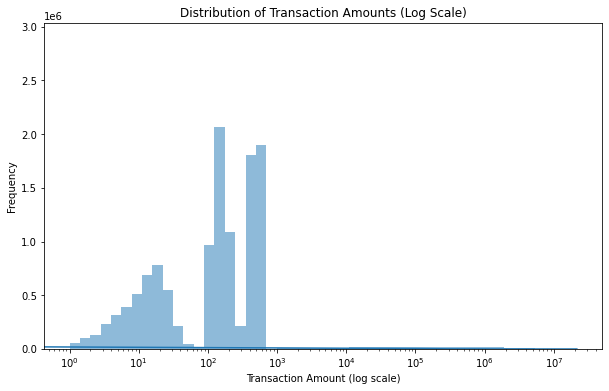

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(transac['TX_AMOUNT'], kde=True, bins=np.logspace(0, np.log10(transac['TX_AMOUNT'].max()), 50))
plt.xscale('log')
plt.title('Distribution of Transaction Amounts (Log Scale)')
plt.xlabel('Transaction Amount (log scale)')
plt.ylabel('Frequency')
plt.show()

### 1.3.2 - Transactions au cours du temps

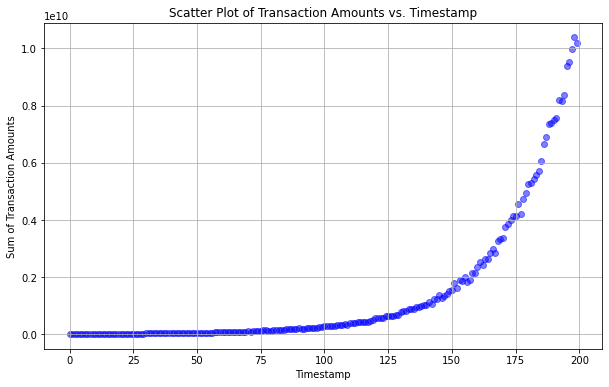

In [17]:
# Group by 'TIMESTAMP' and sum the 'TX_AMOUNT' for each group
grouped_transac = transac.groupby('TIMESTAMP')['TX_AMOUNT'].sum().reset_index()


plt.figure(figsize=(10, 6))
plt.scatter(grouped_transac['TIMESTAMP'], grouped_transac['TX_AMOUNT'], color='blue', alpha=0.5)

plt.xlabel('Timestamp')
plt.ylabel('Sum of Transaction Amounts')
plt.title('Scatter Plot of Transaction Amounts vs. Timestamp')

# Show the plot
plt.grid(True)
plt.show()

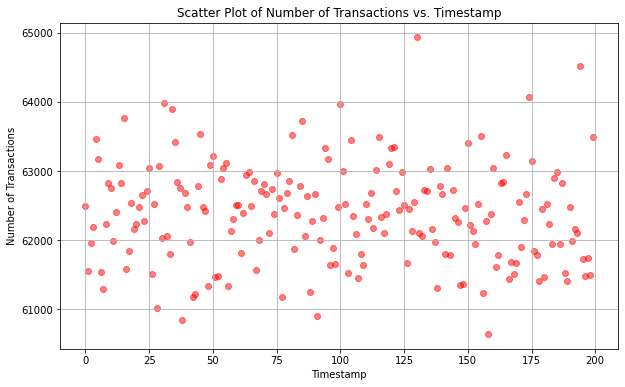

In [18]:
# Group by 'TIMESTAMP' and count the number of transactions for each group
transaction_counts = transac.groupby('TIMESTAMP')['TX_ID'].count().reset_index()

# Rename the column for clarity
transaction_counts.rename(columns={'TX_ID': 'Transaction_Count'}, inplace=True)

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(transaction_counts['TIMESTAMP'], transaction_counts['Transaction_Count'], color='red', alpha=0.5)

# Set the labels and title
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.title('Scatter Plot of Number of Transactions vs. Timestamp')

# Show the plot
plt.grid(True)
plt.show()

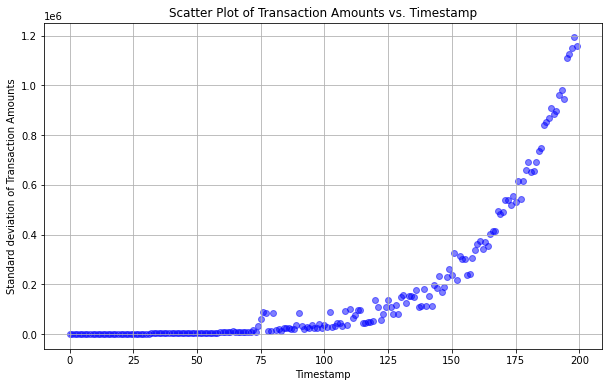

In [26]:
# Group by 'TIMESTAMP' and sum the 'TX_AMOUNT' for each group
grouped_transac = transac.groupby('TIMESTAMP')['TX_AMOUNT'].std().reset_index()


plt.figure(figsize=(10, 6))
plt.scatter(grouped_transac['TIMESTAMP'], grouped_transac['TX_AMOUNT'], color='blue', alpha=0.5)

plt.xlabel('Timestamp')
plt.ylabel('Standard deviation of Transaction Amounts')
plt.title('Scatter Plot of Transaction Amounts vs. Timestamp')

# Show the plot
plt.grid(True)
plt.show()

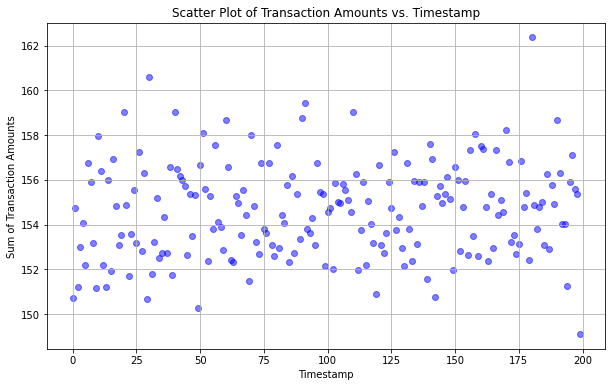

In [23]:
# Group by 'TIMESTAMP' and sum the 'TX_AMOUNT' for each group
grouped_transac = transac.groupby('TIMESTAMP')['TX_AMOUNT'].median().reset_index()


plt.figure(figsize=(10, 6))
plt.scatter(grouped_transac['TIMESTAMP'], grouped_transac['TX_AMOUNT'], color='blue', alpha=0.5)

plt.xlabel('Timestamp')
plt.ylabel('Sum of Transaction Amounts')
plt.title('Scatter Plot of Transaction Amounts vs. Timestamp')

# Show the plot
plt.grid(True)
plt.show()

# 2 - Generation des variables

Ces variables seront utilisées dans le notebook 2 et le notebook 3.

In [3]:
# Sent (Debit) Features
sent_summary = transac.groupby('SENDER_ACCOUNT_ID').agg(
    num_sent=('TX_ID', 'count'),
    total_sent=('TX_AMOUNT', 'sum'),
    avg_sent=('TX_AMOUNT', 'mean'),
    median_sent=('TX_AMOUNT', 'median'),
    std_sent=('TX_AMOUNT', 'std'),
    avg_duration_sent=('TIMESTAMP', lambda x: x.diff().mean()),
    median_duration_sent=('TIMESTAMP', lambda x: x.diff().median()),
    std_duration_sent=('TIMESTAMP', lambda x: x.diff().std())
).reset_index()

# Add unique counterparties and highest counterparty percentage for debit
sent_counterparties = transac.groupby('SENDER_ACCOUNT_ID')['RECEIVER_ACCOUNT_ID'].nunique().reset_index()
sent_counterparties = sent_counterparties.rename(columns={'RECEIVER_ACCOUNT_ID': 'unique_counterparties_sent'})

# Percentage of the highest counterparty by transaction amount
sent_max_counterparty = transac.groupby(['SENDER_ACCOUNT_ID', 'RECEIVER_ACCOUNT_ID'])['TX_AMOUNT'].sum().reset_index()
sent_max_counterparty = sent_max_counterparty.groupby('SENDER_ACCOUNT_ID').apply(lambda x: x['TX_AMOUNT'].max() / x['TX_AMOUNT'].sum()).reset_index()
sent_max_counterparty = sent_max_counterparty.rename(columns={0: 'max_counterparty_percentage_sent'})

# Merge all debit features
sent_summary = sent_summary.merge(sent_counterparties, on='SENDER_ACCOUNT_ID')
sent_summary = sent_summary.merge(sent_max_counterparty, on='SENDER_ACCOUNT_ID')
sent_summary = sent_summary.rename(columns={'SENDER_ACCOUNT_ID': 'ACCOUNT_ID'})

# Received (Credit) Features
received_summary = transac.groupby('RECEIVER_ACCOUNT_ID').agg(
    num_received=('TX_ID', 'count'),
    total_received=('TX_AMOUNT', 'sum'),
    avg_received=('TX_AMOUNT', 'mean'),
    median_received=('TX_AMOUNT', 'median'),
    std_received=('TX_AMOUNT', 'std'),
    avg_duration_received=('TIMESTAMP', lambda x: x.diff().mean()),
    median_duration_received=('TIMESTAMP', lambda x: x.diff().median()),
    std_duration_received=('TIMESTAMP', lambda x: x.diff().std())
).reset_index()

# Add unique counterparties and highest counterparty percentage for credit
received_counterparties = transac.groupby('RECEIVER_ACCOUNT_ID')['SENDER_ACCOUNT_ID'].nunique().reset_index()
received_counterparties = received_counterparties.rename(columns={'SENDER_ACCOUNT_ID': 'unique_counterparties_received'})

# Percentage of the highest counterparty by transaction amount
received_max_counterparty = transac.groupby(['RECEIVER_ACCOUNT_ID', 'SENDER_ACCOUNT_ID'])['TX_AMOUNT'].sum().reset_index()
received_max_counterparty = received_max_counterparty.groupby('RECEIVER_ACCOUNT_ID').apply(lambda x: x['TX_AMOUNT'].max() / x['TX_AMOUNT'].sum()).reset_index()
received_max_counterparty = received_max_counterparty.rename(columns={0: 'max_counterparty_percentage_received'})

# Merge all credit features
received_summary = received_summary.merge(received_counterparties, on='RECEIVER_ACCOUNT_ID')
received_summary = received_summary.merge(received_max_counterparty, on='RECEIVER_ACCOUNT_ID')
received_summary = received_summary.rename(columns={'RECEIVER_ACCOUNT_ID': 'ACCOUNT_ID'})

# Merge the sent and received summaries on ACCOUNT_ID
account_summary = pd.merge(sent_summary, received_summary, on='ACCOUNT_ID', how='outer')

# Calculate the ratios and add them as new features
account_summary['ratio_max_contributor'] = account_summary['max_counterparty_percentage_sent'] / account_summary['max_counterparty_percentage_received']
account_summary['ratio_total_sent_received'] = account_summary['total_sent'] / account_summary['total_received']
account_summary['ratio_avg_sent_received'] = account_summary['avg_sent'] / account_summary['avg_received']
account_summary['ratio_num_sent_received'] = account_summary['num_sent'] / account_summary['num_received']
account_summary['ratio_median_sent_received'] = account_summary['median_sent'] / account_summary['median_received']
account_summary['ratio_std_sent_received'] = account_summary['std_sent'] / account_summary['std_received']

# Handle division by zero or infinite values
account_summary.replace([float('inf'), -float('inf')], 0, inplace=True)
account_summary.fillna(0, inplace=True)

# Merge with the accounts table to add the IS_FRAUD column and other details
account_summary = pd.merge(account_summary, accounts[['ACCOUNT_ID', 'IS_FRAUD']], on='ACCOUNT_ID', how='left')
account_summary['IS_FRAUD'] = account_summary['IS_FRAUD'].astype(int)

# Recap
credit_features = [col for col in account_summary.columns if "received" in col and not col.startswith("ratio")]
debit_features = [col for col in account_summary.columns if "sent" in col and not col.startswith("ratio")]
credit_debit_ratios = [col for col in account_summary.columns if col.startswith("ratio")]

print(f"Our primary key is ACCOUNT_ID.\n")
print("Our credit features are:")
for feature in credit_features:
    print(f"  - {feature}")

print("\nOur debit features are:")
for feature in debit_features:
    print(f"  - {feature}")

print("\nOur credit/debit ratio features are:")
for feature in credit_debit_ratios:
    print(f"  - {feature}")

print(f"\nOur target is 'IS_FRAUD'.\n")
print(f"So we have a total of {len(credit_features)} credit features, {len(debit_features)} debit features, and {len(credit_debit_ratios)} credit/debit ratio features, which makes it a total of {len(credit_features) + len(debit_features) + len(credit_debit_ratios)} features.")

# Display the final DataFrame
df = account_summary
display(df)

print(f"\nOn va maintenant conserver nos features en tant que fichiers .csv que l'on utilisera dans les notebooks suivants.")
df.to_csv(f"12M_trans/AML_features.csv",index=False)
print(f"\nNos features ont été gardées dans le fichier suivant : AML_features.csv")

Our primary key is ACCOUNT_ID.

Our credit features are:
  - num_received
  - total_received
  - avg_received
  - median_received
  - std_received
  - avg_duration_received
  - median_duration_received
  - std_duration_received
  - unique_counterparties_received
  - max_counterparty_percentage_received

Our debit features are:
  - num_sent
  - total_sent
  - avg_sent
  - median_sent
  - std_sent
  - avg_duration_sent
  - median_duration_sent
  - std_duration_sent
  - unique_counterparties_sent
  - max_counterparty_percentage_sent

Our credit/debit ratio features are:
  - ratio_max_contributor
  - ratio_total_sent_received
  - ratio_avg_sent_received
  - ratio_num_sent_received
  - ratio_median_sent_received
  - ratio_std_sent_received

Our target is 'IS_FRAUD'.

So we have a total of 10 credit features, 10 debit features, and 6 credit/debit ratio features, which makes it a total of 26 features.


,ACCOUNT_ID,num_sent,total_sent,avg_sent,median_sent,std_sent,avg_duration_sent,median_duration_sent,std_duration_sent,unique_counterparties_sent,...,std_duration_received,unique_counterparties_received,max_counterparty_percentage_received,ratio_max_contributor,ratio_total_sent_received,ratio_avg_sent_received,ratio_num_sent_received,ratio_median_sent_received,ratio_std_sent_received,IS_FRAUD
0,0,20,3688.80,184.440000,184.44,0.000000,9.789474,10.0,8.256842,1,...,7.736740,1.0,1.000000,1.000000,30.653149,33.718464,0.909091,33.718464,0.000000,0
1,1,23,4043.40,175.800000,175.80,0.000000,8.090909,4.5,9.860499,1,...,9.899495,1.0,1.000000,1.000000,0.001636,0.000213,7.666667,0.000949,0.000000,0
2,2,21,2983.05,142.050000,142.05,0.000000,8.800000,8.5,6.638009,1,...,0.000000,1.0,1.000000,1.000000,1.126700,1.073047,1.050000,1.073047,0.000000,0
3,3,16,2014.08,125.880000,125.88,0.000000,12.533333,10.0,11.457167,1,...,0.000000,1.0,1.000000,1.000000,0.980374,1.225467,0.800000,1.225467,0.000000,0
4,4,44,3324.64,75.560000,75.56,0.000000,4.465116,0.0,8.278914,2,...,9.263208,1.0,1.000000,0.500000,8.581931,3.900878,2.200000,3.900878,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99995,59,18670.59,316.450678,327.16,57.680410,3.103448,0.0,6.616539,5,...,0.508474,42.0,0.495147,0.672390,0.001356,0.013196,0.102787,2.658109,0.000219,1
99996,99996,63,17260.74,273.980000,273.98,0.000000,3.096774,0.0,6.413893,3,...,0.521233,32.0,0.665491,0.500883,0.001844,0.014720,0.125249,2.345518,0.000000,0
99997,99997,93,26611.58,286.146022,289.10,28.487137,1.869565,0.0,4.425742,5,...,0.442939,42.0,0.287262,0.869817,0.001804,0.014448,0.124832,1.972706,0.000153,1
99998,99998,81,17916.89,221.196173,223.91,24.424444,1.987500,0.0,5.845032,6,...,0.399298,62.0,0.174629,1.145023,0.000514,0.006362,0.080838,1.609011,0.000083,1



On va maintenant conserver nos features en tant que fichiers .csv que l'on utilisera dans les notebooks suivants.

Nos features ont été gardées dans le fichier suivant : AML_features.csv


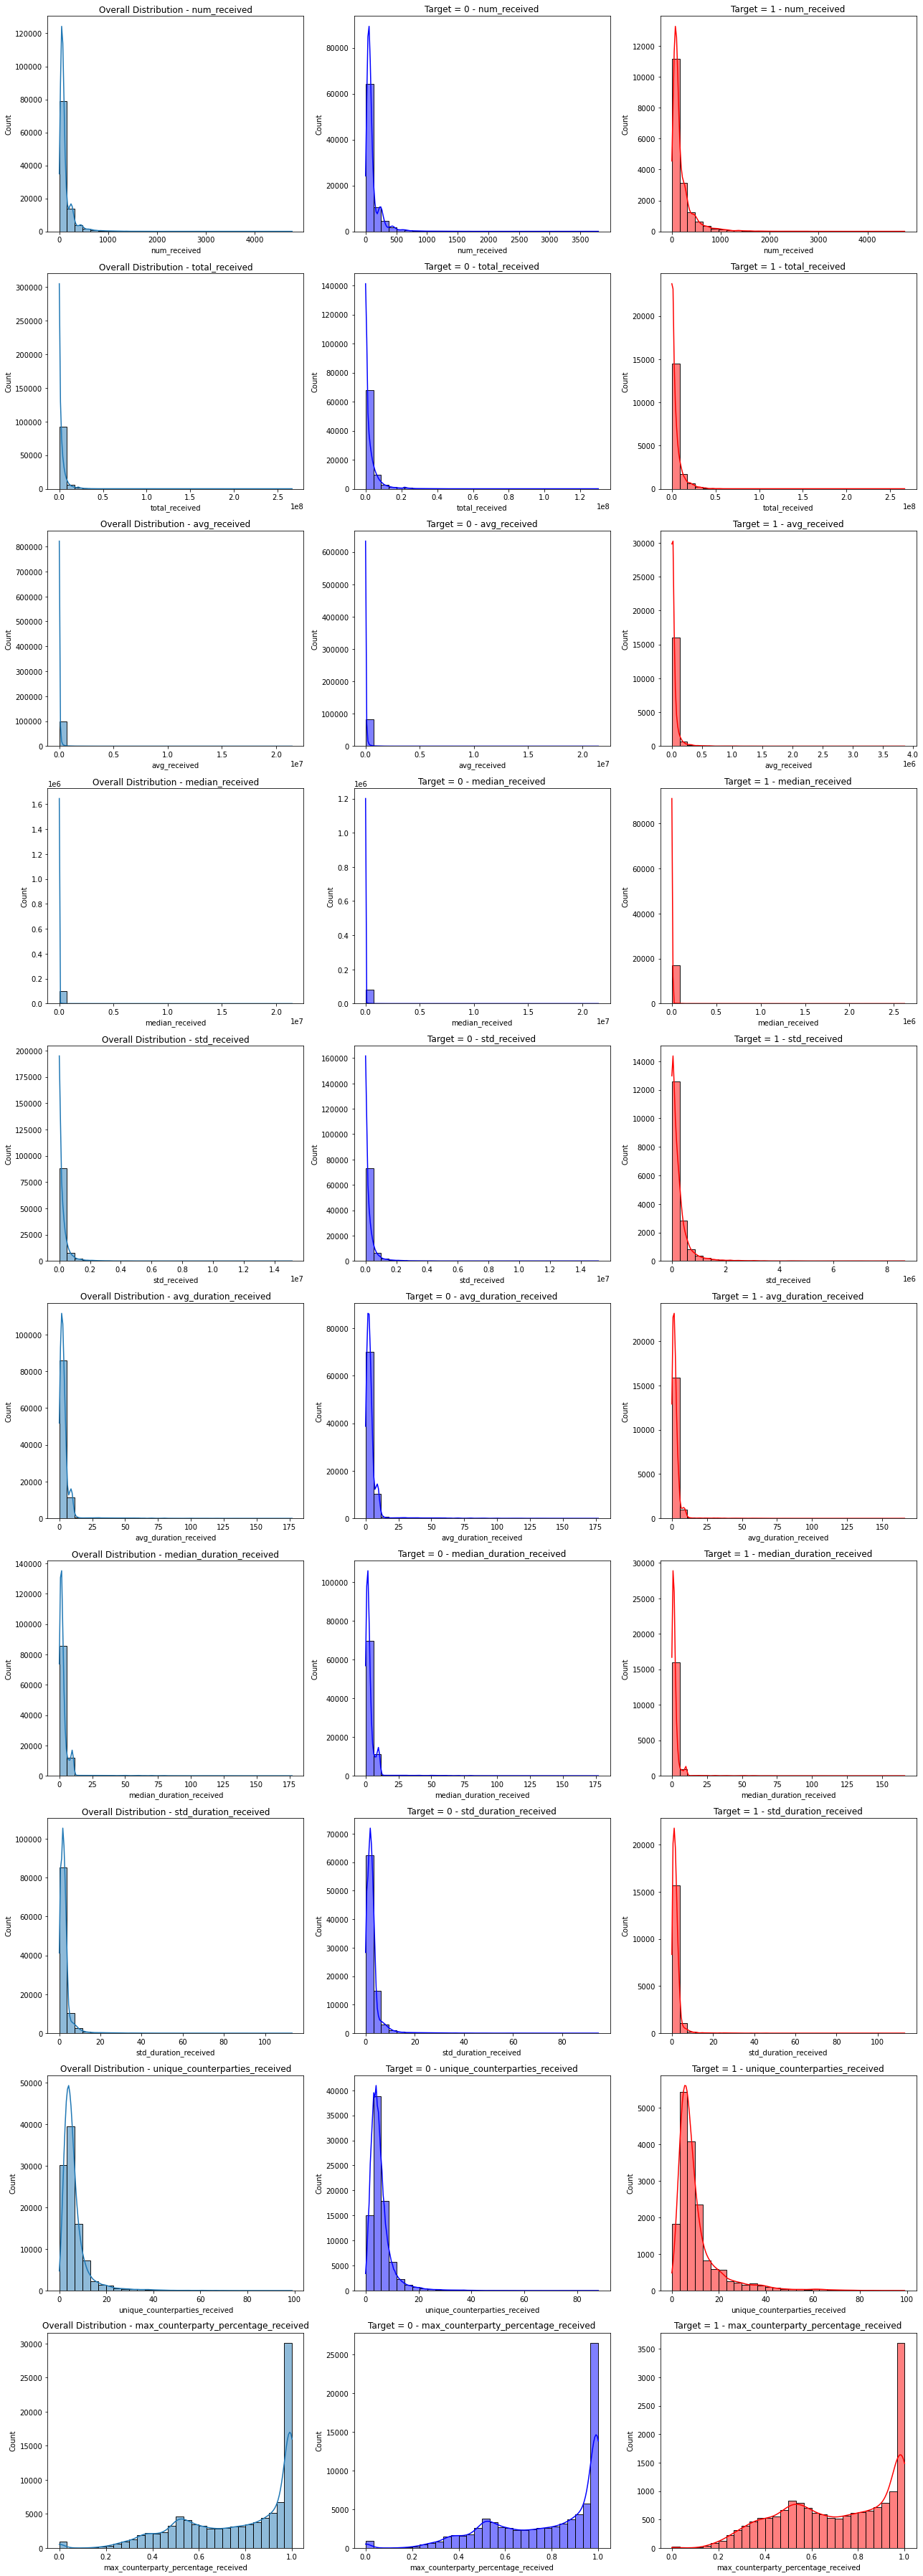

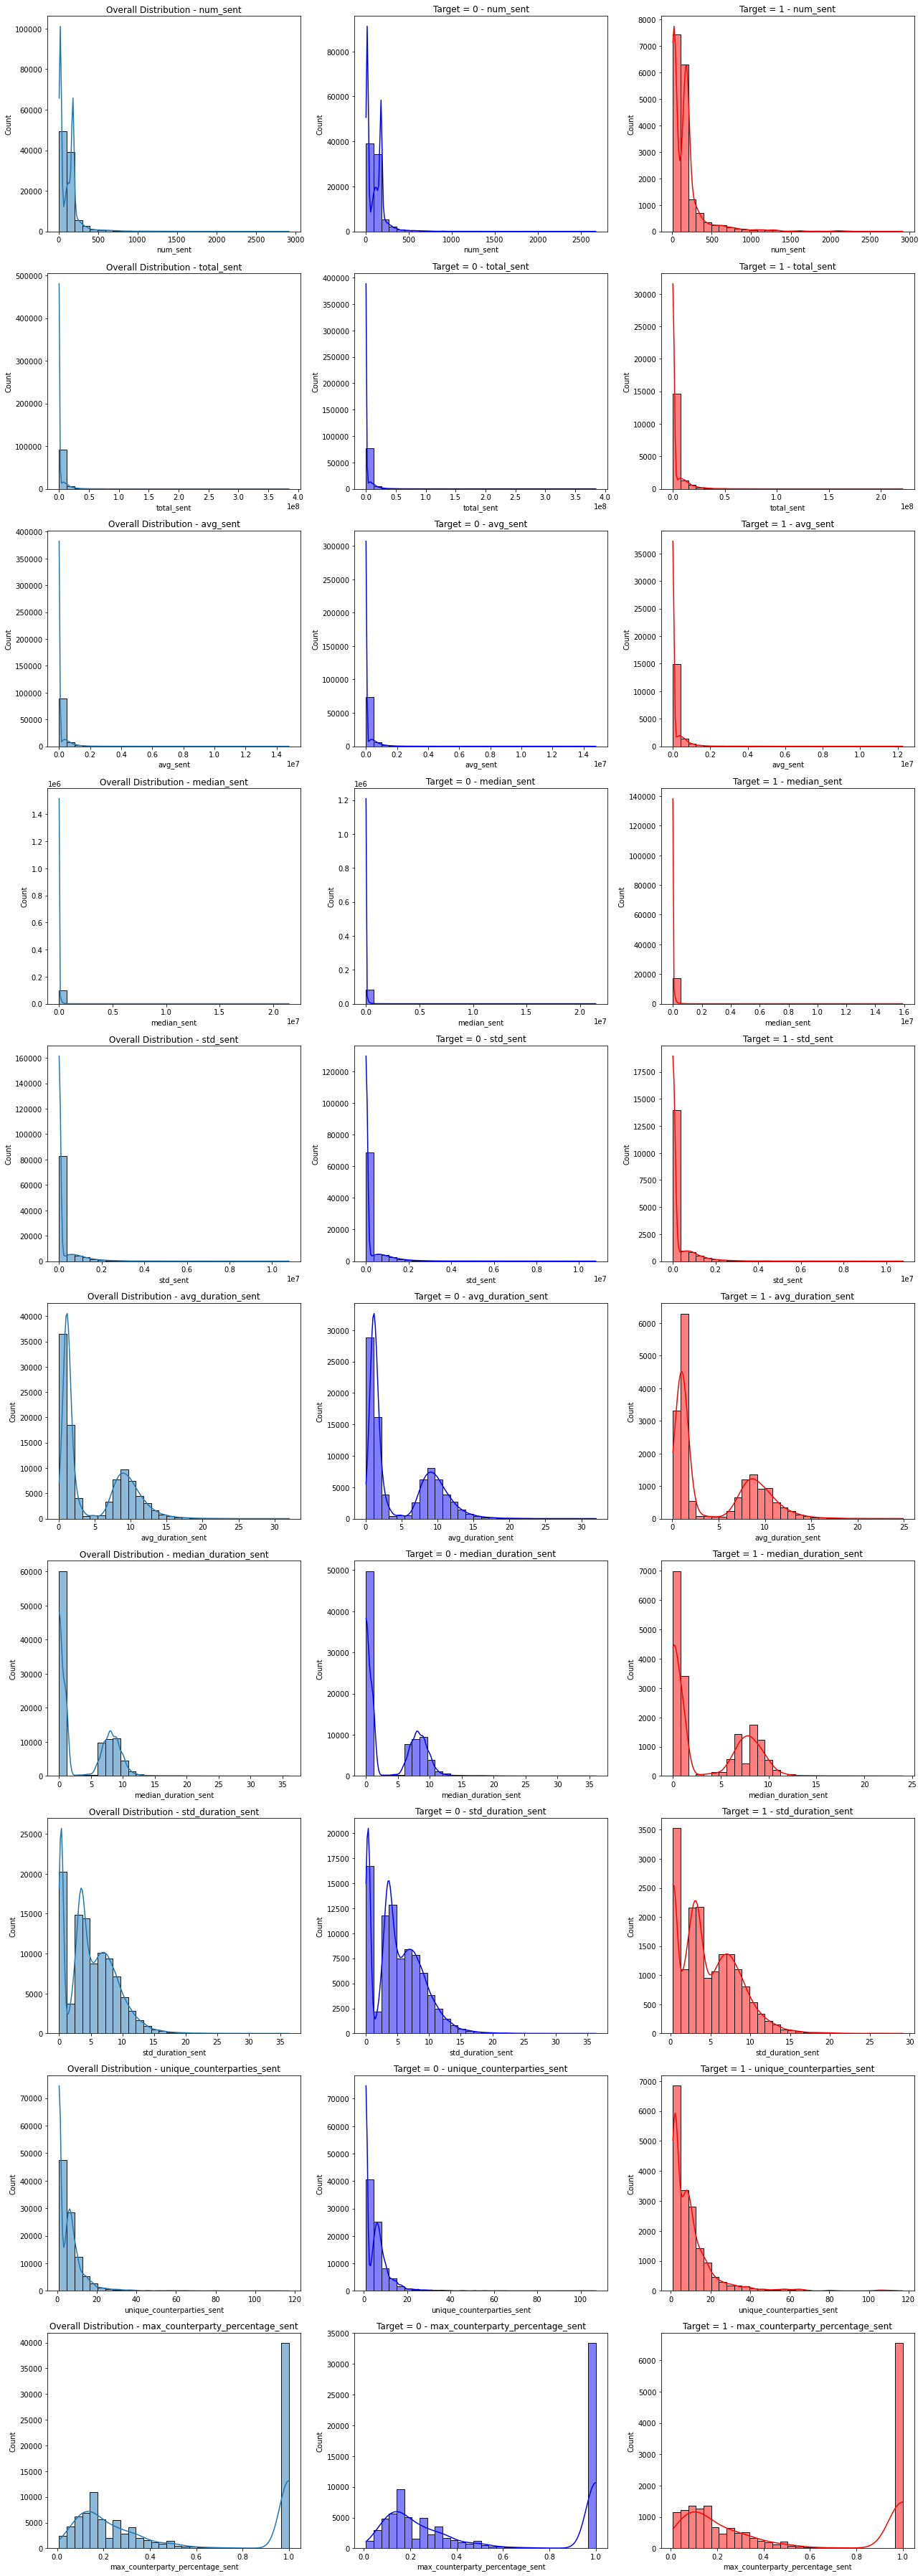

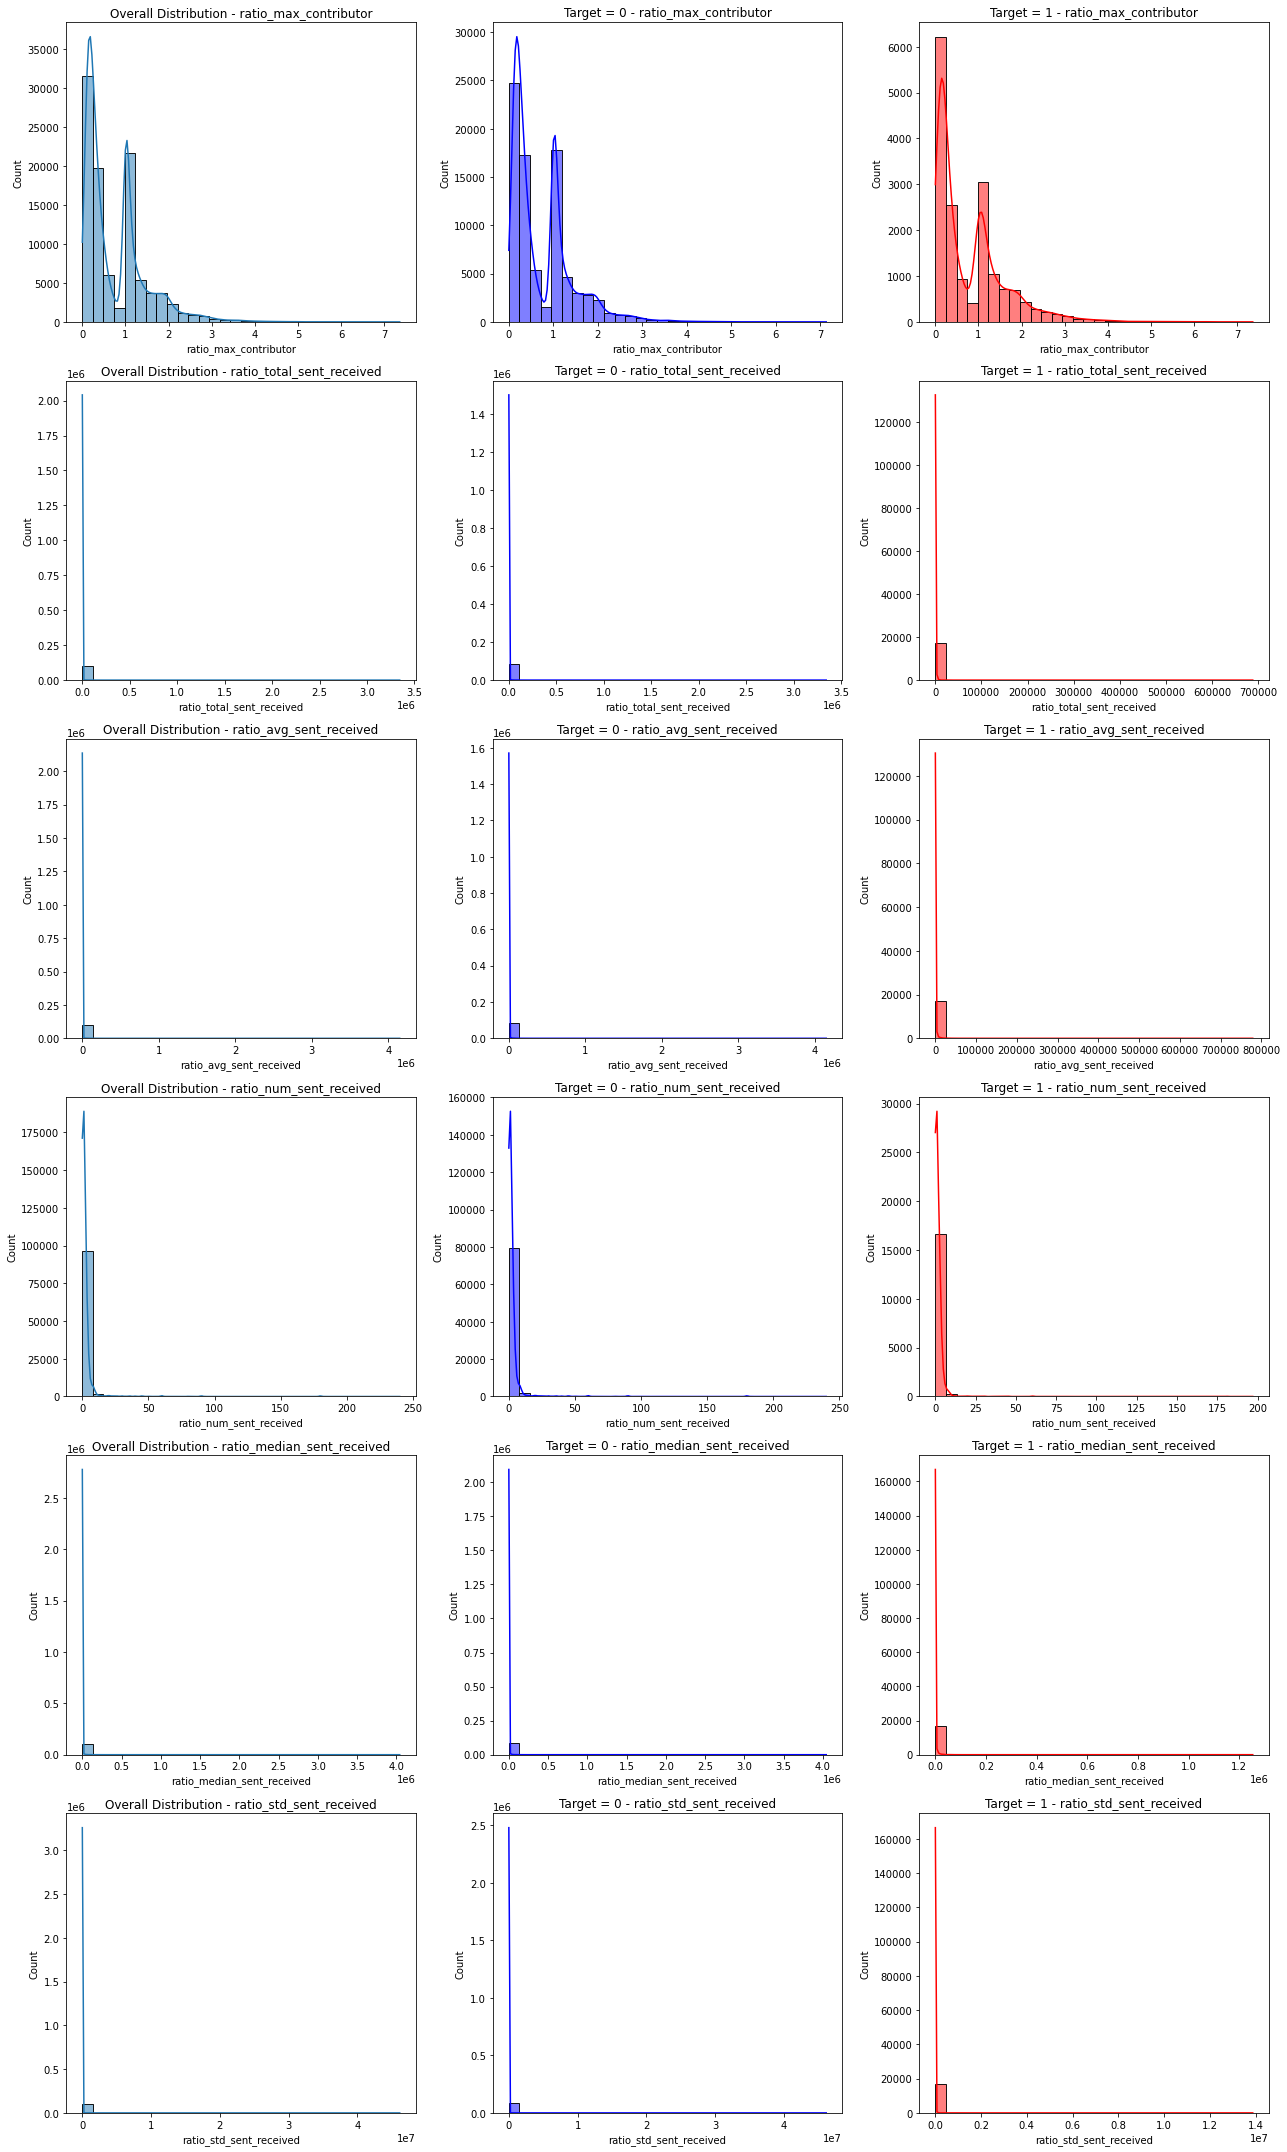

In [24]:
# Function to plot the distributions
def plot_feature_distributions(features, title_prefix):
    plt.figure(figsize=(18, len(features) * 5))
    for i, feature in enumerate(features):
        plt.subplot(len(features), 3, i * 3 + 1)
        sns.histplot(df[feature], kde=True, bins=30)
        plt.title(f'Overall Distribution - {feature}')

        plt.subplot(len(features), 3, i * 3 + 2)
        sns.histplot(df[df['IS_FRAUD'] == 0][feature], kde=True, bins=30, color='blue')
        plt.title(f'Target = 0 - {feature}')

        plt.subplot(len(features), 3, i * 3 + 3)
        sns.histplot(df[df['IS_FRAUD'] == 1][feature], kde=True, bins=30, color='red')
        plt.title(f'Target = 1 - {feature}')

    plt.tight_layout()
    plt.show()

# Plot distributions for credit features
plot_feature_distributions(credit_features, "Credit Feature")

# Plot distributions for debit features
plot_feature_distributions(debit_features, "Debit Feature")

# Plot distributions for credit/debit ratios
plot_feature_distributions(credit_debit_ratios, "Credit/Debit Ratio Feature")

In [ ]:
def plot_boxplots(features, title_prefix):
    plt.figure(figsize=(18, len(features) * 5))
    for i, feature in enumerate(features):
        plt.subplot(len(features), 1, i + 1)
        sns.boxplot(x='IS_FRAUD', y=feature, data=df)
        plt.title(f'Box Plot - {feature}')
    plt.tight_layout()
    plt.show()

# Plot box plots for credit features
plot_boxplots(credit_features, "Credit Feature")

# Plot box plots for debit features
plot_boxplots(debit_features, "Debit Feature")

# Plot box plots for credit/debit ratios
plot_boxplots(credit_debit_ratios, "Credit/Debit Ratio Feature")

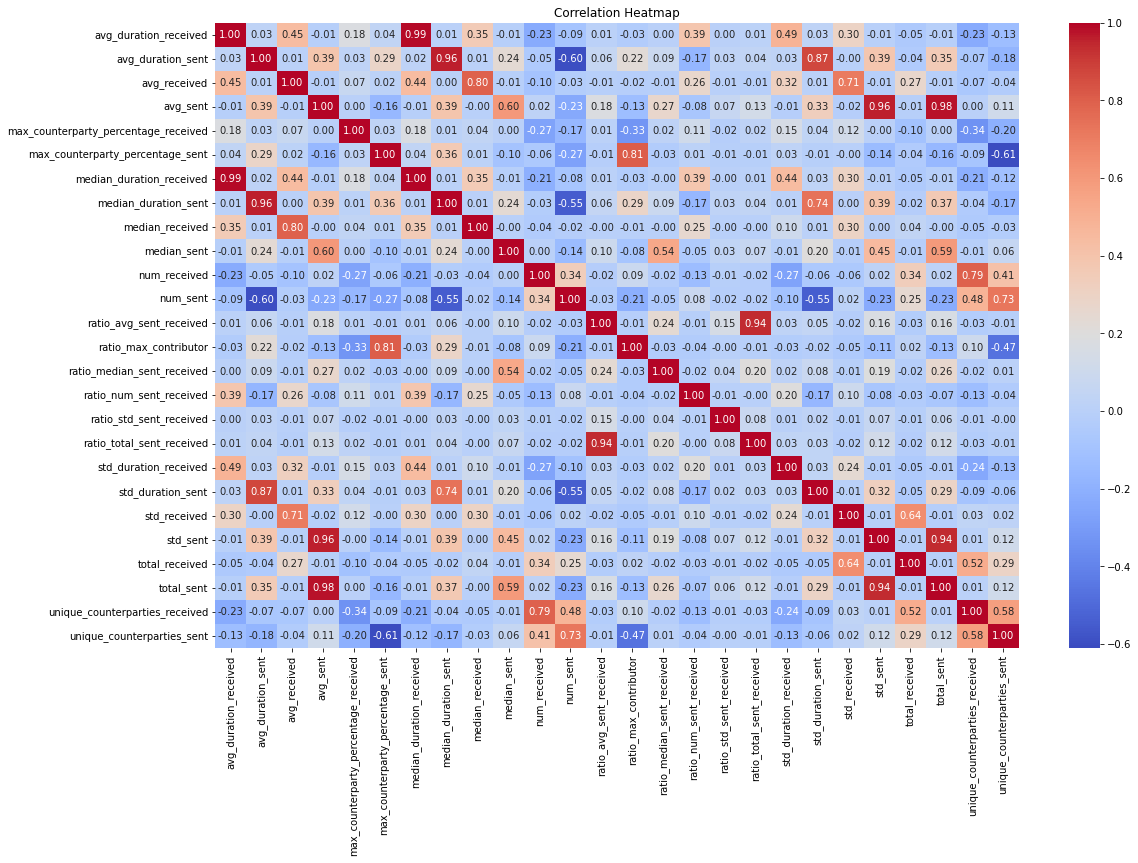

In [25]:
columns_to_include = df.columns.difference(['ACCOUNT_ID', 'IS_FRAUD'])
plt.figure(figsize=(18, 11.5))
sns.heatmap(df[columns_to_include].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()